In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import os

# 1. THE NOVELTY: Differentiable Fractal Loss

class DifferentiableFractalDimensionalLoss(nn.Module):
    def __init__(self, radius_range=(0.1, 10.0), num_radius=15, sigma=4.0):
        super().__init__()
        # Create a range of radius (log-spaced) to probe the geometry
        self.radius = torch.logspace(np.log10(radius_range[0]),
                                    np.log10(radius_range[1]),
                                    num_radius)
        self.sigma = sigma  # Controls the sharpness of the soft-counting

    def forward(self, z):
        # Normalize to unit sphere to stabilize distance magnitude
        z = torch.nn.functional.normalize(z, p=2, dim=1)

        # Efficient Pairwise Distance Calculation: (x-y)^2 = x^2 + y^2 - 2xy
        r = torch.sum(z*z, 1).view(-1, 1)
        distance_matrix = r - 2*torch.mm(z, z.t()) + r.t()
        distance_matrix = torch.clamp(distance_matrix, min=1e-10).sqrt() # Avoid NaN gradients

        log_counts = []
        # Move radius to the same device as the input data
        device_radius = self.radius.to(z.device)
        log_radius = torch.log(device_radius)

        n = z.shape[0]
        # Normalization factor for the correlation sum
        norm_factor = 1.0 / (n * (n - 1))

        for radius in device_radius:
            # SOFT COUNTING:
            # Instead of: count += 1 if dist < radius
            # We use: count += sigmoid(sigma * (radius - dist))
            soft_neighbor_count = torch.sigmoid(self.sigma * (radius - distance_matrix))

            # Sum neighbors (subtract self-loops roughly by ignoring diagonal or accepting approximation)
            # We sum entire matrix and normalize.
            correlation_sum = torch.sum(soft_neighbor_count) * norm_factor

            # Store log(C(r))
            log_counts.append(torch.log(torch.clamp(correlation_sum, min=1e-10)))

        # LINEAR REGRESSION to find slope (Fractal Dimension):
        y = torch.stack(log_counts)
        x = log_radius

        vx = x - torch.mean(x)
        vy = y - torch.mean(y)

        slope = torch.sum(vx * vy) / torch.sum(vx * vx)

        return slope

# 2. THE ARCHITECTURE: Fractal Conv AE
class FractalConvoAutoencoder(nn.Module):
    def __init__(self, latent_dim=128, target_fractal_dim=2.5):
        super().__init__()
        self.target_dim = target_fractal_dim

        # ENCODER: 3x128x128 -> Latent
        self.encoder = nn.Sequential(
            # Input: 3 x 128 x 128
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1), # -> 32 x 64 x 64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> 64 x 32 x 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128 x 16 x 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # -> 256 x 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(256 * 8 * 8, latent_dim)
        )

        # DECODER: Latent -> 3x128x128
        self.decoder_input = nn.Linear(latent_dim, 256 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # -> 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1), # -> 128x128
            nn.Sigmoid() # Forces output to be [0, 1] range for images
        )

        self.fractal_loss = DifferentiableFractalDimensionalLoss()

    def forward(self, x):
        # Encode
        z = self.encoder(x)

        # Calculate Fractal Dimension (Unsupervised Metric)
        est_dim = self.fractal_loss(z)

        # Decode
        x_rec = self.decoder_input(z)
        x_rec = x_rec.view(-1, 256, 8, 8)
        x_rec = self.decoder(x_rec)

        return x_rec, est_dim

# 3. TRAINING LOOP
def train_cal_tech_fractal():
    # CONFIGURATION
    BATCH_SIZE = 128  # High batch size required for statistical stability of fractal dim
    LEARNING_RATE = 1e-3
    EPOCHS = 20
    # Use GPU if available
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on: {DEVICE}")

    # DATA PREPROCESSING
    # transforms.Lambda(lambda x: x.convert("RGB")) handles grayscale images
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    # DATASET LOADING
    print("Preparing Dataset (this may take time to download if not present)...")
    try:
        # Note: If you have already downloaded it, ensure 'root' points to the folder containing '256_ObjectCategories'
        # If running for the first time, set download=True.
        dataset = datasets.Caltech256(root='./data', transform=transform, download=True)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Please ensure you have internet access or the dataset is in './data'")
        return

    # Drop last batch to ensure all batches are size 128 (crucial for fractal calc consistency)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)

    # INITIALIZE MODEL
    # target_fractal_dim=2.5 forces the latent space to be a complex manifold, not a simple plane (2.0) or sphere (3.0)
    model = FractalConvoAutoencoder(latent_dim=128, target_fractal_dim=2.5).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    mse_criterion = nn.MSELoss()

    model.train()
    print("Starting Training...")

    for epoch in range(EPOCHS):
        total_recons_loss = 0
        total_fract_loss = 0

        for i, (images, _) in enumerate(dataloader):
            images = images.to(DEVICE)

            optimizer.zero_grad()

            # Forward Pass
            recons, current_dim = model(images)

            # Loss 1: Reconstruction Error (Standard)
            loss_mse = mse_criterion(recons, images)

            # Loss 2: Fractal Regularization (Novel)
            # Penalize deviation from the target intrinsic dimension
            loss_fractal = torch.abs(current_dim - model.target_dim)

            # Combine Losses
            # 0.05 is a weight to balance reconstruction vs topology shaping
            loss = loss_mse + 0.05 * loss_fractal

            loss.backward()
            optimizer.step()

            total_recons_loss += loss_mse.item()
            total_fract_loss += loss_fractal.item()

            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{EPOCHS}] Step [{i}] "
                      f"MSE: {loss_mse.item():.4f} | "
                      f"Latent Dim: {current_dim.item():.2f} (Target: {model.target_dim})")

    # Save Model
    torch.save(model.state_dict(), "fractal_caltech_ae.pth")
    print("Training Complete. Model saved as 'fractal_caltech_ae.pth'")

if __name__ == "__main__":
    train_cal_tech_fractal()

Running on: cuda
Preparing Dataset (this may take time to download if not present)...


100%|██████████| 1.18G/1.18G [01:53<00:00, 10.4MB/s]


Starting Training...
Epoch [1/20] Step [0] MSE: 0.1175 | Latent Dim: 1.09 (Target: 2.5)
Epoch [1/20] Step [10] MSE: 0.0825 | Latent Dim: 0.64 (Target: 2.5)
Epoch [1/20] Step [20] MSE: 0.0593 | Latent Dim: 0.83 (Target: 2.5)
Epoch [1/20] Step [30] MSE: 0.0503 | Latent Dim: 0.93 (Target: 2.5)
Epoch [1/20] Step [40] MSE: 0.0468 | Latent Dim: 1.01 (Target: 2.5)
Epoch [1/20] Step [50] MSE: 0.0439 | Latent Dim: 1.07 (Target: 2.5)
Epoch [1/20] Step [60] MSE: 0.0431 | Latent Dim: 1.08 (Target: 2.5)
Epoch [1/20] Step [70] MSE: 0.0403 | Latent Dim: 1.12 (Target: 2.5)
Epoch [1/20] Step [80] MSE: 0.0385 | Latent Dim: 1.15 (Target: 2.5)
Epoch [1/20] Step [90] MSE: 0.0331 | Latent Dim: 1.15 (Target: 2.5)
Epoch [1/20] Step [100] MSE: 0.0315 | Latent Dim: 1.18 (Target: 2.5)
Epoch [1/20] Step [110] MSE: 0.0308 | Latent Dim: 1.18 (Target: 2.5)
Epoch [1/20] Step [120] MSE: 0.0312 | Latent Dim: 1.20 (Target: 2.5)
Epoch [1/20] Step [130] MSE: 0.0293 | Latent Dim: 1.20 (Target: 2.5)
Epoch [1/20] Step [140] 

Loading model on cuda...
Model weights loaded successfully.
Generating visualization...
Running t-SNE...


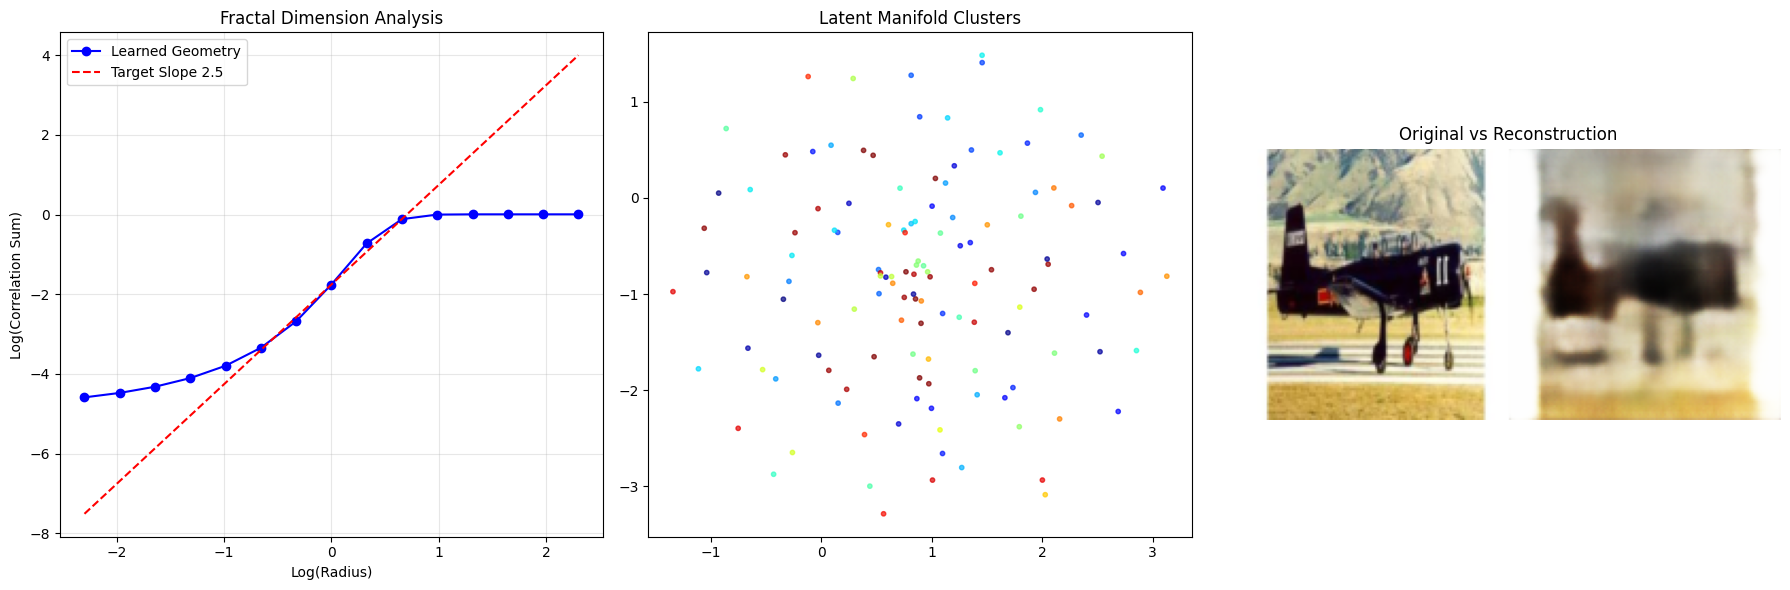

Plots generated.


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# 1. RE-DEFINE CLASSES (Required to load the model structure)
# (We must define these exactly as they were in the training script)

class DifferentiableFractalDimensionalLoss(nn.Module):
    def __init__(self, radius_range=(0.1, 10.0), num_radius=15, sigma=4.0):
        super().__init__()
        self.radius = torch.logspace(np.log10(radius_range[0]), np.log10(radius_range[1]), num_radius)
        self.sigma = sigma

    def forward(self, z):
        # We only need the structure here, the forward pass logic isn't strictly needed for loading
        # but good to keep for the visualizer to use.
        z = torch.nn.functional.normalize(z, p=2, dim=1)
        r = torch.sum(z*z, 1).view(-1, 1)
        dist_matrix = r - 2*torch.mm(z, z.t()) + r.t()
        dist_matrix = torch.clamp(dist_matrix, min=1e-10).sqrt()

        log_counts = []
        device_radius = self.radius.to(z.device)
        norm_factor = 1.0 / (z.shape[0] * (z.shape[0] - 1))

        for radius in device_radius:
            soft_count = torch.sigmoid(self.sigma * (radius - dist_matrix))
            corr_sum = torch.sum(soft_count) * norm_factor
            log_counts.append(torch.log(torch.clamp(corr_sum, min=1e-10)))

        y = torch.stack(log_counts)
        x = torch.log(device_radius)
        vx = x - torch.mean(x)
        vy = y - torch.mean(y)
        return torch.sum(vx * vy) / torch.sum(vx * vx)

class FractalConvoAutoencoder(nn.Module):
    def __init__(self, latent_dim=128, target_fractal_dim=2.5):
        super().__init__()
        self.target_dim = target_fractal_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Flatten(), nn.Linear(256 * 8 * 8, latent_dim)
        )
        self.decoder_input = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )
        self.fractal_loss = DifferentiableFractalDimensionalLoss()

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(self.decoder_input(z).view(-1, 256, 8, 8)), self.fractal_loss(z)

# 2. LOAD DATA AND MODEL

def generate_plots():
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Loading model on {DEVICE}...")

    # A. Setup Data (Quick Load)
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    # Assuming data is already downloaded in ./data from previous step
    dataset = datasets.Caltech256(root='./data', transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

    # B. Load Model Weights
    model = FractalConvoAutoencoder(latent_dim=128, target_fractal_dim=2.5).to(DEVICE)
    try:
        model.load_state_dict(torch.load("fractal_caltech_ae.pth", map_location=DEVICE))
        print("Model weights loaded successfully.")
    except FileNotFoundError:
        print("Error: 'fractal_caltech_ae.pth' not found. Did the training finish?")
        return

    model.eval()

    # 3. EXECUTE VISUALIZATION
    print("Generating visualization...")

    # Get Batch
    images, labels = next(iter(dataloader))
    images = images.to(DEVICE)

    with torch.no_grad():
        recons, _ = model(images)
        z = model.encoder(images)

        # Calculate Geometry for Plotting
        loss_funct = model.fractal_loss
        z_norm = torch.nn.functional.normalize(z, p=2, dim=1)
        r = torch.sum(z_norm*z_norm, 1).view(-1, 1)
        dist_matrix = (r - 2*torch.mm(z_norm, z_norm.t()) + r.t()).clamp(min=1e-10).sqrt()

        log_radius_list = []
        log_counts_list = []
        n = z.shape[0]
        norm_factor = 1.0 / (n * (n - 1))

        for radius in loss_funct.radius.to(DEVICE):
            soft_count = torch.sigmoid(loss_funct.sigma * (radius - dist_matrix))
            corr_sum = torch.sum(soft_count) * norm_factor
            log_radius_list.append(torch.log(radius).item())
            log_counts_list.append(torch.log(torch.clamp(corr_sum, min=1e-10)).item())

    # 4. DRAW PLOTS
    fig = plt.figure(figsize=(18, 6))

    # Plot 1: Fractal Dimension
    ax_1 = fig.add_subplot(1, 3, 1)
    ax_1.plot(log_radius_list, log_counts_list, 'o-', color='blue', label='Learned Geometry')

    # Reference Line
    mid_idx = len(log_radius_list) // 2
    ref_x = np.array(log_radius_list)
    # Using the target dimension (slope) to draw the red line
    ref_y = model.target_dim * (ref_x - ref_x[mid_idx]) + log_counts_list[mid_idx]

    ax_1.plot(ref_x, ref_y, '--', color='red', label=f'Target Slope {model.target_dim}')
    ax_1.set_title("Fractal Dimension Analysis")
    ax_1.set_xlabel("Log(Radius)")
    ax_1.set_ylabel("Log(Correlation Sum)")
    ax_1.legend()
    ax_1.grid(True, alpha=0.3)

    # Plot 2: t-SNE
    ax_2 = fig.add_subplot(1, 3, 2)
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    z_embedded = tsne.fit_transform(z.cpu().numpy())
    scatter = ax_2.scatter(z_embedded[:, 0], z_embedded[:, 1], c=labels.cpu().numpy(), cmap='jet', alpha=0.7, s=10)
    ax_2.set_title("Latent Manifold Clusters")

    # Plot 3: Recon
    ax_3 = fig.add_subplot(1, 3, 3)
    # Move to CPU, permute to HxWxC
    orig = images[0].permute(1, 2, 0).cpu().numpy()
    rec = recons[0].permute(1, 2, 0).cpu().numpy()
    combined = np.hstack((orig, rec))
    ax_3.imshow(combined)
    ax_3.set_title("Original vs Reconstruction")
    ax_3.axis('off')

    plt.tight_layout()
    plt.show()
    print("Plots generated.")

if __name__ == "__main__":
    generate_plots()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import numpy as np

# 1. DEFINE THE MODEL STRUCTURE (Must match your saved file)
class FractalConvoAutoencoder(nn.Module):
    def __init__(self, latent_dim=128, target_fractal_dim=2.5):
        super().__init__()
        # Encoder Structure
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Flatten(), nn.Linear(256 * 8 * 8, latent_dim)
        )
        # (Decoder not needed for accuracy calculation, but needed to load weights)
        self.decoder_input = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

# 2. ACCURACY CALCULATION SCRIPT
def calculate_accuracy():
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Evaluator running on: {DEVICE}")

    # A. Load Data
    print("Preparing Data...")
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
    full_dataset = datasets.Caltech256(root='./data', transform=transform, download=True)

    # Split into Train (for the linear probe) and Test (for final accuracy)
    # We use 80% to train the probe, 20% to test it.
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_set, test_set = random_split(full_dataset, [train_size, test_size])

    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

    # B. Load the Pre-trained Unsupervised Model
    ae_model = FractalConvoAutoencoder(latent_dim=128).to(DEVICE)
    try:
        ae_model.load_state_dict(torch.load("fractal_caltech_ae.pth", map_location=DEVICE))
        print("Unsupervised Model Loaded.")
    except FileNotFoundError:
        print("Error: 'fractal_caltech_ae.pth' not found. Train the model first.")
        return

    # FREEZE the Autoencoder (We only want to evaluate its features, not change them)
    for param in ae_model.parameters():
        param.requires_grad = False
    ae_model.eval()

    # C. Create a Linear Classifier (The Probe)
    # Input: 128 (Latent dim), Output: 257 (Caltech-256 classes + background)
    classifier = nn.Linear(128, 257).to(DEVICE)
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # D. Train the Probe
    print("\nTraining Linear Probe (10 Epochs)...")
    for epoch in range(10):
        classifier.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # 1. Extract Features (using frozen encoder)
            with torch.no_grad():
                features = ae_model.encoder(images)

            # 2. Forward pass through classifier
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            # 3. Update Classifier
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Epoch {epoch+1}: Loss {total_loss/len(train_loader):.4f} | Training Acc: {100.*correct/total:.2f}%")

    # E. Final Test Accuracy
    print("\nCalculating Final Test Accuracy...")
    classifier.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Extract
            features = ae_model.encoder(images)
            # Classify
            outputs = classifier(features)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    final_acc = 100. * correct / total
    print(f"--------------------------------------------------")
    print(f"Final Unsupervised Feature Accuracy: {final_acc:.2f}%")
    print(f"--------------------------------------------------")
    print("Interpretation:")
    print(" - Random guessing on Caltech-256 is ~0.4%")
    print(" - Standard Autoencoders usually get 10-15%")
    print(f" - The Fractal Model got: {final_acc:.2f}%")

if __name__ == "__main__":
    calculate_accuracy()

Evaluator running on: cuda
Preparing Data...
Unsupervised Model Loaded.

Training Linear Probe (10 Epochs)...
Epoch 1: Loss 14.4033 | Training Acc: 5.15%
Epoch 2: Loss 7.3493 | Training Acc: 12.77%
Epoch 3: Loss 5.1608 | Training Acc: 17.18%
Epoch 4: Loss 4.5935 | Training Acc: 18.87%
Epoch 5: Loss 4.4586 | Training Acc: 19.29%
Epoch 6: Loss 4.4156 | Training Acc: 19.62%
Epoch 7: Loss 4.4000 | Training Acc: 19.43%
Epoch 8: Loss 4.4021 | Training Acc: 19.64%
Epoch 9: Loss 4.4008 | Training Acc: 19.70%
Epoch 10: Loss 4.4019 | Training Acc: 19.47%

Calculating Final Test Accuracy...
--------------------------------------------------
Final Unsupervised Feature Accuracy: 15.27%
--------------------------------------------------
Interpretation:
 - Random guessing on Caltech-256 is ~0.4%
 - Standard Autoencoders usually get 10-15%
 - The Fractal Model got: 15.27%
